# Module 2 Final Project Submission
### SQL EDA and Hypothesis Testing

Student name: Fernando Aguilar Islas<br>
Student pace: Part Time<br>
Scheduled project review date/time: TBA<br>
Instructor name: Brandon Lewis<br>
Blog post URL:<br>
Video Walkthrough URL:<br>

## 1. Introduction
For this project I will solve relevant questions utilizing hypothesis testing and statistical analysis using information from the Northwind Database, published by Micorsoft. The tables contain company's information about operating regions, suppliers, employees, clients, orders, and products. Below is the Entity Relationship Diagram (ERD) of the database I will be working with.<br>
### Northwind's SQL Database

<img src='Northwind_ERD.png'>

## 2. Objective <br>

The priority is to find startegies that will increase Northiwind's profits, hence, I will be looking into solutions that either increase revenue or cut down costs. The following questions will be answered thoruought the notebook, each with its own section stating its null and alternate hypothesis, and carrying out statistical testing to verify the significance of the findings. This will enable me to provide Northwind with relevant recommendations in how to improve their operations to obtain a higher profit.<br>

1. **Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**
2. **Do different regions have different employee productivity?**
3. **Are price elasticities different accross products?**
4. **Another good question?**
5. **Another great question?**<br>

## 3. Methodology <br>
Throughout the project, in order to answer each of the stated questions, I will extract the necessary data from the SQL database and perform hypothesis testing. I will perform parametric and/or non-parametric testing to find wether or not we can reject the null hypothesis with a given significance level. Since parametric testing relies on the assumption that the sample data has a specific distribution (usually Gaussian), I will start by testing this assumption using the Shapiro–Wilk test. Then, based on the results I will proceed with hypothesis testing accordingly, state the confidence level (Type I error), and arrive to conclusions to provide statistically significant recommendations. This recommendations have the goal of increasing revenues, decresing costs or identify unique areas of opportunity to increase profits.<br>

Since the data is in an SLQ database I will start by loading all the necessary libraries to access, and retrieve the data into pandas dataframes for ease of manipulation. I will also load libraries to transform, and visualize data as well as the necessary tools to carry out EDA and hypothesis testing. After obtaining the necessary tools and establishing a connection to the database, I will go ahead and answer the first question.

In [1]:
#Import sql libraries to retrieve, manipulate and explore data from database.
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import sqlite3 as sql

#Import tools for Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np

#Import tools for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import tools for hypothesis testing
from scipy import stats
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler

#Helper functions for presentation purposes
from ipywidgets import interact, interactive
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Create engine, session and inspector to access and retrieve data in the database.
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)

2019-06-03 17:10:45,910 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-03 17:10:45,911 INFO sqlalchemy.engine.base.Engine ()
2019-06-03 17:10:45,912 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-03 17:10:45,912 INFO sqlalchemy.engine.base.Engine ()


In [11]:
'''Often times, actual table and column names differ to the ones in the ERD.
Hence, it is helpfull to get the table names form the actual database to
avoid errors during the retreival of data and EDA.'''
# Obtain and store the names of tables in database as as list.
db_tables=inspector.get_table_names()
db_tables

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

### 3.1 Helper functions.

## 4.  Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?<br>
<br>

> $H_{0}:$ *Discounts do not have an effect on the number of products ordered.*$$ <br> 
> $H_{1}:$ *Discounts have an effect on the number of products ordered.* $\mu_0 =\mu1 $ <br>
> Significance Level: $\alpha = 0.05$ *Probability of a Type I error*<br>

To conduct this hypothesis testing I will retrieve the required data from the OrderDetail table wich cointains infrormaton about quantities ordered and the discounts offered. 

In [37]:
df_order = pd.read_sql_query("SELECT Quantity, Discount FROM [OrderDetail]", engine)
#Check for null values and correct datatype.
print(df_order.info(), '\n')
#Descriptive statistics.
print(df_order.describe())
#Visualize first lines of dataframe.
df_order.head()

2019-06-04 11:15:58,680 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM [OrderDetail]
2019-06-04 11:15:58,681 INFO sqlalchemy.engine.base.Engine ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB
None 

          Quantity     Discount
count  2155.000000  2155.000000
mean     23.812993     0.056167
std      19.022047     0.083450
min       1.000000     0.000000
25%      10.000000     0.000000
50%      20.000000     0.000000
75%      30.000000     0.100000
max     130.000000     0.250000


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


From this initial data exploration, I can confirm that the data is in the correct datatype as well that it conforms with common sense that there canot be a quantity ordered below 1 or discount below 0. Also, there a no missing values in teh data. First I will start by visulizing the data.

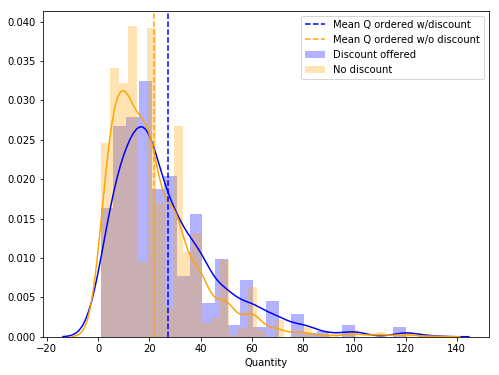

Average quantity ordered with discount:  27
Average quantity ordered without discount:  22
Percentage increase by offering discounts:  24.8421 %


In [90]:
fig = plt.figure(figsize=(8,6))
sns.distplot(df_order[df_order['Discount']>0].Quantity, label='Discount offered', 
             color='blue', hist_kws=dict(alpha=.3))
sns.distplot(df_order[df_order['Discount']== 0].Quantity, label='No discount',
            color='orange', hist_kws=dict(alpha=.3))
plt.axvline(df_order[df_order['Discount']> 0].Quantity.mean(), 0,1, color='blue', 
            linestyle='--', label='Mean Q ordered w/discount')
plt.axvline(df_order[df_order['Discount']== 0].Quantity.mean(), 0,1, color='orange', 
            linestyle='--', label='Mean Q ordered w/o discount' )
plt.legend()
plt.show();
print('Average quantity ordered with discount: ',round(df_order[df_order['Discount']>0].Quantity.mean()))
print('Average quantity ordered without discount: ',round(df_order[df_order['Discount']== 0].Quantity.mean()))
print('Percentage increase by offering discounts: ',
      round((df_order[df_order['Discount']> 0].Quantity.mean()-df_order[df_order['Discount']== 0].Quantity.mean())/
     df_order[df_order['Discount']== 0].Quantity.mean()*100, 4),'%')

Since quantities ordered and dicounts cannot be negative, most outliers will be extreme order quantities that positivley skew the distribution. I will use the Shapiro–Wilk test to see if the distribution of the data is normal enough to perform a  two-sample t-test, difference of means. 

In [52]:
stats.shapiro(df_order[df_order['Discount']> 0].Quantity)[1]

6.88120409395894e-26

In [9]:
df_orders = df_order.set_index('Id').join(df_orderd.set_index('OrderId'))

In [10]:
df_orders.head()

,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,ProductId,UnitPrice,Quantity,Discount
10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,11,14.0,12,0.0
10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/42,42,9.8,10,0.0
10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/72,72,34.8,5,0.0
10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/14,14,18.6,9,0.0
10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/51,51,42.4,40,0.0


## 5.  Another question?<br>

In [7]:
df_order = pd.read_sql_query("SELECT * FROM [Order]", engine)
df_order.head()

2019-06-03 17:11:23,152 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-06-03 17:11:23,153 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
